The goal of this notebook is to get started with random forest and apply it to our data.

## Libraries imports

In [ ]:
!cp "/content/drive/MyDrive/Statapp/file_04_HMLasso.py" "HMLasso.py"
!cp "/content/drive/MyDrive/Statapp/manipulate_data.py" "manipulate_data.py"

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler # To standardize the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

# from cuml.ensemble import RandomForestClassifier # Classifier
# from cuml.ensemble import RandomForestRegressor # Regressor
from sklearn.ensemble import RandomForestClassifier # Classifier
from sklearn.ensemble import RandomForestRegressor # Regressor
import HMLasso as hml # Lasso with High Missing Rate
import manipulate_data as manip # Useful functions

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

import time # To measure elapsed time during simulation

## Data imports

In [ ]:
columns_types = pd.read_csv("/content/drive/MyDrive/Statapp/data_03_columns_types.csv") # Potentialy useless
data = pd.read_csv("/content/drive/MyDrive/Statapp/data_04.csv") # We use one hot encoded variables
data.info(memory_usage="deep")

<ipython-input-3-e8eae813f21d>:2: DtypeWarning: Columns (2684) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/drive/MyDrive/Statapp/data_04.csv") # We use one hot encoded variables


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42232 entries, 0 to 42231
Columns: 11429 entries, HHIDPN to R14IADL5H_5
dtypes: float64(11377), int64(51), object(1)
memory usage: 3.6 GB


## Trying RandomForest

### Using Lasso

In [ ]:
# Get (X, y)
untimed_data = manip.drop_time(data, keep_genetic=False)
print(untimed_data.info(memory_usage="deep"))

X = untimed_data.drop(columns=["HHIDPN", "GHIw"]).values
y = untimed_data["GHIw"].values

y_scaled = y - y.mean()
X_scaled = StandardScaler().fit_transform(X)

# Fit the HMLasso
hml.ERRORS_HANDLING = "ignore"
lasso = hml.HMLasso(mu = 100, verbose = False)
lasso.fit(X_scaled, y_scaled)

# The lasso dropped some columns. We save the ones that we shall not drop
columns_for_lasso = untimed_data.drop(columns = ["HHIDPN", "GHIw"]).columns
criteria = pd.Series(abs(lasso.beta_opt) > 1e-9)
columns_to_keep = list(pd.Series(columns_for_lasso)[criteria.index[criteria]])

# Loading only individuals present in all waves.
waves = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
columns_to_keep_for_each_wave = [var.replace('w', str(wave)) for var in columns_to_keep for wave in waves] + [var for var in data.columns if 'genetic_' in var]
working_data = manip.get_sample(data, waves = waves)

# We finally select columns agreed by the lasso
working_data = working_data[['HHIDPN'] + columns_to_keep_for_each_wave + [f'GHI{wave}' for wave in range(1, 15)]]
print(working_data.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264618 entries, 0 to 264617
Columns: 455 entries, HHIDPN to GHIw
dtypes: float64(454), int64(1)
memory usage: 918.6 MB
None
[Warning] Sigma_opt is not PSD, its minimum eigenvalue is (-3.9297837355401136e-05+0j). Error handled by adding (3.9297837355401136e-05-0j) to each eigenvalue.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3396 entries, 0 to 3395
Columns: 1822 entries, HHIDPN to GHI14
dtypes: float64(1820), int64(1), object(1)
memory usage: 47.4 MB
None


In [ ]:
del data

### RandomForest Regressor

In [ ]:
def train_model(working_data, data_to_use="all", params_grid=None, how="regressor", n_bins=5, random_state=None, verbose=False):
  """
  Main function to train RandomForest model.
  
  inputs:
  - working_data: the database on which the estimator will be trained and tested.
  - data_to_use:
     > 'all' = socioeconomic data, genetic data, precedent GHI are used for prediction
     > 'socio' = only socioeconomic data are used
     > 'sociogenetic' = only socioeconomic and genetic data are used
     > 'socioghi' = only socioeconomic data and precedent GHI are used
  - simulation:
     > 'short' = only a few hyperparameters will be tested. Does not take more than 10 minutes.
     > 'long' = a lot of hyperparameters will be tested. Can take up to 3h.
  - params_grid: the parameters to cross validate. If this option is specified, simulation is ignored.
  - how:
     > 'regressor' = a RandomForestRegressor will be trained.
     > 'classifier' = a RandomForestClassifier will be trained.
    n_bins: number of bins for the classifier. Ignored if how == 'regressor'.
  - random_state: the random_state used in the split train/test.
  - verbose: True or False

  Preferred use: before using this function, apply lasso to select relevant columns.
  """
  assert how in ["regressor", "classifier"]
  if verbose:
    print(how, " model will be fitted.")

  ##############################################################################
  # Creating (X, y)
  ##############################################################################

  ##################### 'data_to_use' handling #################################
  message = {'all' : "Socioeconomic data, genetic data, precedent GHI will be used for prediction.",
             'socio' : "Only socioeconomic data will be used for prediction.",
             'sociogenetic' : "Only socioeconomic data and genetic data will be used for prediction.",
             'socioghi' : "Only socioeconomic data and precedent GHI will be used for prediction."}

  basic_columns = ["genetic_VERSION", "genetic_Section_A_or_E", "HHIDPN", "GHI14"]
  genetic_columns = [col for col in working_data.columns if 'genetic_' in col and col != 'genetic_VERSION' and col != 'genetic_Section_A_or_E']
  GHI_columns = [f'GHI{wave}' for wave in range(1, 14)]

  if data_to_use == 'all':
    columns_to_delete = basic_columns
  elif data_to_use == 'socio':
    columns_to_delete = basic_columns + genetic_columns + GHI_columns
  elif data_to_use == 'sociogenetic':
    columns_to_delete = basic_columns + GHI_columns
  elif data_to_use == 'socioghi':
    columns_to_delete = basic_columns + genetic_columns
  
  if verbose:
    print(message[data_to_use])

  if data_to_use in ['all', 'socio', 'sociogenetic', 'socioghi']:
    X = working_data.drop(columns = columns_to_delete)
  elif data_to_use == 'ghi':
    X = working_data[GHI_columns]

  ############################### select y #####################################
  if how == "regressor":
    y = working_data["GHI14"]
  if how == "classifier":
    y = pd.cut(working_data["GHI14"], n_bins, labels=list(range(n_bins)))

  # Splitting into Training and Testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

  # Imputing variables
  imp = SimpleImputer(strategy="mean")
  imp.fit(X_train)
  X_train = imp.transform(X_train)
  X_test = imp.transform(X_test)

  ##############################################################################
  # Performing cross-validation to train and fine-tune the model
  ##############################################################################

  ############################# select model ###################################
  if how == "regressor":
    model = RandomForestRegressor()
  if how == "classifier":
    model = RandomForestClassifier()

  ########################### select scoring method ############################
  if how == "regressor":
    scoring = 'r2'
  if how == "classifier":
    scoring = 'accuracy'

  ########################### Training the model ###############################
  grid = GridSearchCV(model, params_grid, refit = True,
                      verbose = verbose, n_jobs=-1, scoring=scoring) 
  grid.fit(X_train, y_train)

  results = pd.DataFrame(grid.cv_results_)

  if verbose:
    print("Model refitted with best hyperparameters.")
    print("Best parameters : " + str(grid.best_params_))
    print("R2 score on train : ", str(grid.score(X_train, y_train)))
    print("R2 score on test : ", str(grid.score(X_test, y_test)))
  
  # Storing results
  final_results = {}
  final_results["data"] = data_to_use
  final_results["best_parameters"] = list(grid.best_params_.items())

  y_train_pred = grid.predict(X_train)
  y_test_pred = grid.predict(X_test)
  if how == "regressor":
    final_results["r2_train"] = grid.score(X_train, y_train)
    final_results["r2_test"] = grid.score(X_test, y_test)
    final_results["rmse_train"] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    final_results["rmse_test"] = np.sqrt(mean_squared_error(y_test, y_test_pred))

  if how == "classifier":
    final_results["accuracy_train"] = grid.score(X_train, y_train)
    final_results["accuracy_test"] = grid.score(X_test, y_test)

    final_results["recall_train"] = np.nan
    final_results["recall_test"] = np.nan
    final_results["precision_train"] = np.nan
    final_results["precision_test"] = np.nan
    final_results["f1_train"] = np.nan
    final_results["f1_test"] = np.nan
    if n_bins == 2:
      final_results["recall_train"] = recall_score(y_train, y_train_pred)
      final_results["recall_test"] = recall_score(y_test, y_test_pred)
      final_results["precision_train"] = precision_score(y_train, y_train_pred)
      final_results["precision_test"] = precision_score(y_test, y_test_pred)
      final_results["f1_train"] = f1_score(y_train, y_train_pred)
      final_results["f1_test"] = f1_score(y_test, y_test_pred)
      
  return final_results

In [ ]:
# SHORT SIMULATION
params_grid_short = {"n_estimators" : [100, 200], # number of trees
                     "criterion" : ["gini"],
                     "max_depth" : [3, 4, 5],
                     "max_samples" : [0.8, 1.0],
                     "bootstrap" : [True],
                     "verbose" : [1]
                    }

# MEDIUM SIMULATION
params_grid_medium = {"n_estimators" : [100, 200], # number of trees
                     "criterion" : ["squared_error", "absolute_error", "friedman_mse", "poisson"],
                     "max_depth" : [5, 6, 7, 8, 9, 10],
                     "max_samples" : [0.5, 0.7, 1.0],
                     "bootstrap" : [True],
                     "verbose" : [1]
                    }

# LONG SIMULATION
params_grid_long = {
              'n_estimators': [100, 200], # number of trees
              'max_depth': [4, 5, 6], # Lower depth can reduce overfitting
              'max_leaf_nodes': [4, 6],#, 8], # Lower max_leaf_nodes can reduce overfitting
              'min_samples_leaf': [10, 20] #[5, 10, 20] # Higher values can reduce overfitting
              }
params_grid = {"short" : params_grid_short, "long" : params_grid_long, "medium" : params_grid_medium}

In [ ]:
# Initialize the parameters of the simulation
results_regression = {"Iteration" : [], "Data_used" : [], "best_parameters" : [], "r2_train" : [], "r2_test" : [], "rmse_train" : [], "rmse_test" : []}
speed = "short"
number_of_simulations = 10

t0 = time.time()
for iteration in range(number_of_simulations):

  t_beginning = time.time()

  # We train the model and store the results.
  for data_to_use in ['all', 'socio', 'sociogenetic', 'socioghi', 'ghi']:
    result = train_model(working_data, data_to_use=data_to_use, random_state=None, params_grid=params_grid[speed], how="regressor")
    results_regression["Iteration"].append(iteration)
    results_regression["Data_used"].append(data_to_use)
    results_regression["best_parameters"].append(result["best_parameters"])
    results_regression["r2_train"].append(result["r2_train"])
    results_regression["r2_test"].append(result["r2_test"])
    results_regression["rmse_train"].append(result["rmse_train"])
    results_regression["rmse_test"].append(result["rmse_test"])
    
  t_end = time.time()

  print("iteration: ", iteration, " - elapsed_time: ", t_end - t_beginning)

print("Simulation completed.")
print("Overall elapsed_time = ", time.time() - t0)

# Storing the results
results_regression = pd.DataFrame(results_regression).sort_values("r2_test", ascending=False)
results_regression.to_csv("RandomForest_regression_simulation.csv", index=False)

# Display 
results_regression.groupby(["Data_used"])["r2_test", "rmse_test"].agg({"mean", "std", "count", "max", "min"})

### Random Forest Classifier

Another way to see the problem is to see whether or not RandomForest is able to classify people with respect to their health.

At the end of section 'Using HMLasso', we have the working_data. Let us construct a new variable, namely 'GHC' for 'Global Health Class' with 5 categories.

In [ ]:
# Initialize the parameters of the simulation
results_classification = {"Iteration": [], "n_bins": [], "best_parameters": [], 
                          "accuracy_train" : [], "accuracy_test": [],
                          "recall_train": [], "recall_test": [],
                          "precision_train": [], "precision_test": [],
                          "f1_train": [], "f1_test": []}
speed = "short"
number_of_simulations = 10
n_bins_max = 11

t0 = time.time()
for iteration in range(0, number_of_simulations):

  t_beginning = time.time()

  # We train the model and store the results.
  for n_bins in range(2, n_bins_max):
    result = train_model(working_data, data_to_use='all', random_state=None, params_grid=params_grid[speed], how="classifier", n_bins=n_bins)
    results_classification["Iteration"].append(iteration)
    results_classification["n_bins"].append(n_bins)
    results_classification["best_parameters"].append(result["best_parameters"])
    results_classification["accuracy_train"].append(result["accuracy_train"])
    results_classification["accuracy_test"].append(result["accuracy_test"])
    
    results_classification["recall_train"].append(result["recall_train"])
    results_classification["recall_test"].append(result["recall_test"])
    results_classification["precision_train"].append(result["precision_train"])
    results_classification["precision_test"].append(result["precision_test"])
    results_classification["f1_train"].append(result["f1_train"])
    results_classification["f1_test"].append(result["f1_test"])
    
  t_end = time.time()

  print("iteration: ", iteration, " - elapsed_time: ", t_end - t_beginning)

print("Simulation completed.")
print("Overall elapsed_time = ", time.time() - t0)

# Storing the results
results_classification = pd.DataFrame(results_classification).sort_values("accuracy_test", ascending=False)
results_classification.to_csv("RandomForest_classification_simulation.csv", index=False)

# Display 
results_classification.groupby(["n_bins"])["accuracy_test"].agg({"mean", "std", "count", "max", "min"})

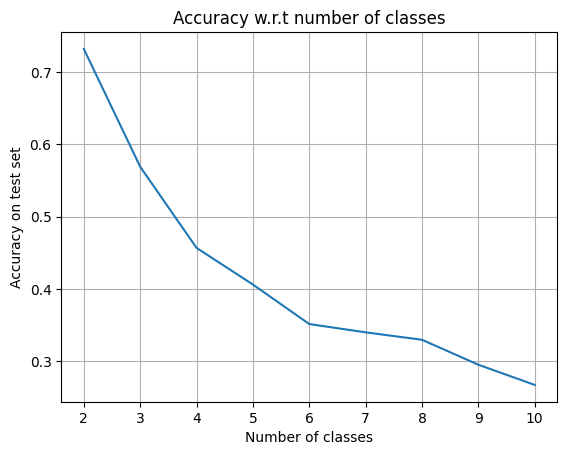

In [ ]:
results_classification.groupby(["n_bins"])["accuracy_test"].mean().plot()
plt.grid()
plt.xlabel("Number of classes")
plt.ylabel("Accuracy on test set")
plt.title("Accuracy w.r.t number of classes")
plt.show()

In [ ]:
results_classification.groupby(["n_bins"])["accuracy_test"].mean()*results_classification.groupby(["n_bins"])["accuracy_test"].mean().index

n_bins
2     1.464412
3     1.707353
4     1.827059
5     2.030147
6     2.107941
7     2.378971
8     2.636471
9     2.655000
10    2.670588
dtype: float64

In [ ]:
results_classification.groupby(["n_bins"])["accuracy_test"].mean()

n_bins
2     0.732206
3     0.569118
4     0.456765
5     0.406029
6     0.351324
7     0.339853
8     0.329559
9     0.295000
10    0.267059
Name: accuracy_test, dtype: float64

In [ ]:
results_classification.groupby(["n_bins"])["accuracy_test", "f1_test", "recall_test", "precision_test"].mean()

<ipython-input-12-01ca52aef037>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results_classification.groupby(["n_bins"])["accuracy_test", "f1_test", "recall_test", "precision_test"].mean()


,accuracy_test,f1_test,recall_test,precision_test
n_bins,,,,
2,0.732206,0.764571,0.777158,0.752893
3,0.569118,NaN,NaN,NaN
4,0.456765,NaN,NaN,NaN
5,0.406029,NaN,NaN,NaN
6,0.351324,NaN,NaN,NaN
7,0.339853,NaN,NaN,NaN
8,0.329559,NaN,NaN,NaN
9,0.295000,NaN,NaN,NaN
10,0.267059,NaN,NaN,NaN
